# Table of contents
1. [Introduction](#introduction)
2. [Some paragraph](#paragraph1)
    1. [Sub paragraph](#subparagraph1)
3. [Another paragraph](#paragraph2)

## This is the introduction <a name="introduction"></a>
Some introduction text, formatted in heading 2 style


## Welcome to my SLOG <a name="introduction"></a>
Hey everyone, so this is something I just made up: A script Log. Like a Video Log but in neat Python Script with hopefully lots of interesting projects going on in it. Ideas will arbitrarily go into this, but projects will be put together (Intro, Body, Appendix) and linked via the table of contents above - hope this works. 

## Project 1: A horserace of asset allocations, based on [Andrew Ang's book on factor investing](https://www.amazon.de/Asset-Management-Systematic-Investing-Association-ebook/dp/B00KW69ORW)
Imagine you were sitting on the board of some large investor and you would like to decide on an approach for your strategic asset allocation. The following strategies might cross your mind: 

* Mean Variance approach: 
    * Idea: You maximize the sharpe ratio of your portfolio by assuming mean returns, volatilities and correlations will stay roughly the same over the long run.
    * Pro: Theorically sound
    * Con: You have to estimate the above-mentioned variables, and assume them to remain stable.  
* Minimum Variance:
    * Idea: You minimize the volatlity of your portfolio by assuming volatilities and correlations will stay roughly the same over the long run.
    * Pro: Less volatility of the above and theoretically efficient if there is no risk-free rate. Moreover, you do not need to estimate mean returns. 
    * Con: You have to estimate 2 of the above-mentioned variables.
* Risk-Parity: 
    * Idea: You assume that certain assets come with different risk factors, which you would like to be exposed to equally, so that you do not take bets on the development of those risk factors. You keep the risk exposure of your portfolio in *parity* by weighting the assets according to the inverse of their variance ($1/Var(R_i)$)
    * Pro: You are - according to the theory - *truely diversified* because you believe the underlying risk-factors are uncorrelated.  
    * Con: You have to assume risk factors are uncorrelated and still   
* Equally Weighted:
    * Idea: You keep it simple and just allocate all assets to the same degree, thereby selling winners and buying losers on rebalancing.
    * Pro: Very simple and especially successful during high volatility without strong trends.
    * Con: If trends in markets persist over rebalancings and or volatility is low. The strategy will sell what works and buy what doesn't.  
* Trust your PMs: 
    * Idea: You spend a lot of money on PMs, lets just let them do their job. They will try to time the market by overweighting and underweighting asset classes within limits. 
    * Pro: They sit there anyways. 
    * Con: They might bet wrongly. 
* Trust JJ: 
    * Idea: You remember that you met me and you are feeling lucky. 
    * Pro: I would love to do it. 
    * Con: I have no idea what I am doing.  

Luckily, because you are such a long term investor. You have exactly one year to decide what to do. And you decide to give all of these strategies a paper track record during the time. Whoever wins the *horserace* will get your money - fair game. 

**To the data!**

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import quandl
quandl.ApiConfig.api_key = "Jq_aYr5vETsGDgmPVVsA"

In [141]:
Euro_Stoxx50 = quandl.get("CHRIS/EUREX_FESX1")
E_minis500 = quandl.get("CHRIS/CME_ES2")
Gold = quandl.get("CHRIS/CME_GC3")
treasury10y = quandl.get("CHRIS/CME_TY1")
names=["EuroStoxx50","S&P500EMinis","Gold","Treasury10y"]
futures = pd.concat([Euro_Stoxx50["Settle"],E_minis500["Settle"],Gold["Settle"],treasury10y["Settle"]],axis=1)
futures.columns = names
futures.tail()

,EuroStoxx50,S&P500EMinis,Gold,Treasury10y
Date,,,,
2020-01-31,3639.0,3223.50,1587.9,131.656250
2020-02-03,3654.0,3245.50,1582.4,131.578125
2020-02-04,3722.0,3299.75,1555.5,130.890625
2020-02-05,3770.0,3335.25,1562.8,130.546875
2020-02-06,3799.0,3345.50,1570.0,130.562500


By downloading the continouos futures data from Quandl, be get accurate price data for relevant asset classes which we can use for our global portfolio. We get some of the core components of most asset allocations. DM-Equities, Treasuries and Gold. Let's plot this, shall we?

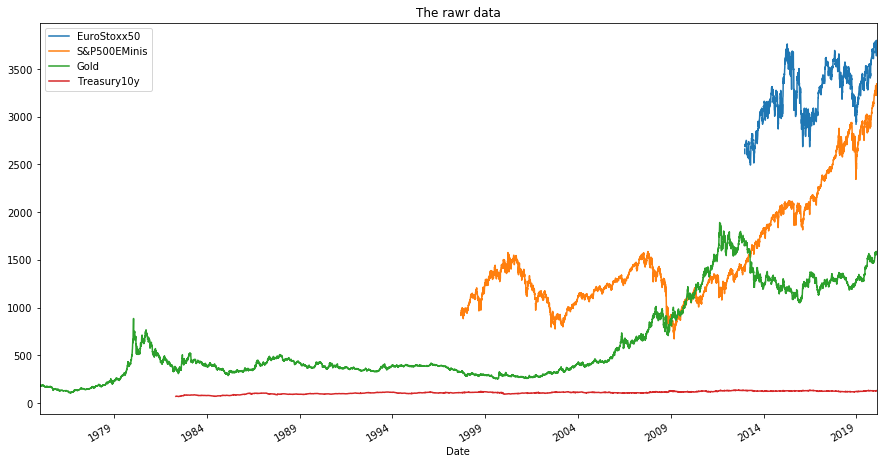

In [142]:
futures.plot(figsize = (15,8),title="The rawr data");

It is fairly obvious, that we still need to do a little bit of data tyding. First of all, we will only consider time periods for which we have good data. According to the plot, the last series to start is the one on of the EuroStoxx 50, sometime around 2012. Secondly, I will also index the data to that date, so that differences levels do not skew what we see. 

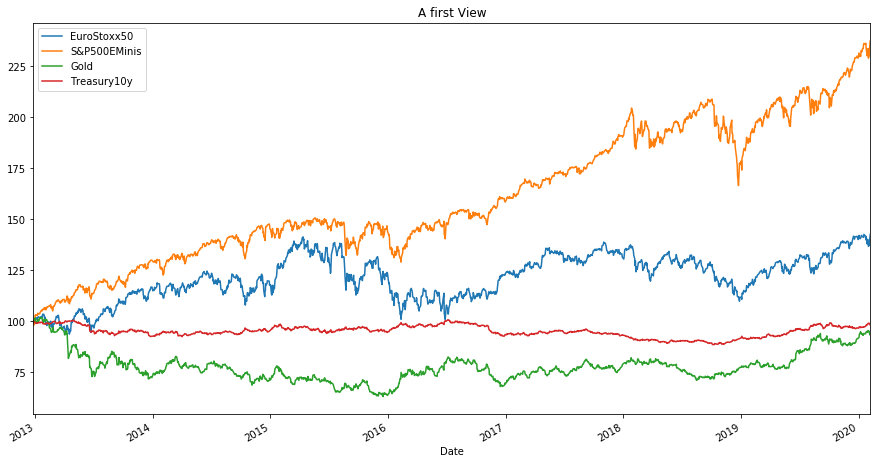

In [143]:
futures = futures.dropna()
futures = (futures/futures.iloc[0])*100
futures.plot(figsize = (15,8),title="A first View");

This gives us a nicely behaved plot in which we can interrpet the final row as percentage increase since the beginning of our data in 2013. Where are we now?

In [144]:
(round(futures.tail(1)-100,1))

,EuroStoxx50,S&P500EMinis,Gold,Treasury10y
Date,,,,
2020-02-06,42.8,137.7,-5.8,-1.8


Looking at this, one has to note that the futures prices do not accurately reflect the price return of the underlyings. However, given our data limitations, lets live with that for now. 

### Data wrangling 
Since we finally have somewhat useful data to solve our portfolio construction problem, lets see what we need to get out of the data to find our portfolios: 
* The mean returns
* The variance-covariance-matrix

Additionally, we need view vectors of our portfolio managers and my input. But lets take that aside for now and get to our estimates just mentioned. 

For convenience, we will take the log returns of the daily data and use that for the annualized mean returns ($average*252$) and our annualized (co-)variances ($variance*252$) 

In [163]:
futures_log = np.log(futures/futures.shift(1)).dropna()
mean_returns = np.array((futures_log.mean()*252))
var_covar = np.mat(futures_log.cov()*252)
variances = np.diagonal(var_covar)

Let's look take a look at mean returns and variances: 

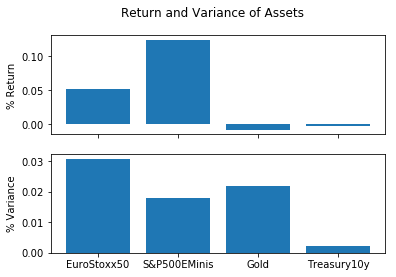

In [164]:
# Make a fake dataset:
fig, axs = plt.subplots(2,sharex=True)
fig.suptitle('Return and Variance of Assets')
axs[0].bar(y_pos, mean_returns)
axs[0].label_outer()
axs[0].set(ylabel='% Return')
axs[1].bar(y_pos, variances)
axs[1].set(ylabel='% Variance')
plt.xticks(y_pos, names);

Next, lets look at the Beta matrix: 

In [172]:
correl_matrix = pd.DataFrame(var_covar/variances)
correl_matrix.columns = names
correl_matrix.index = names
correl_matrix

,EuroStoxx50,S&P500EMinis,Gold,Treasury10y
EuroStoxx50,1.000000,0.744474,-0.243544,-1.260390
S&P500EMinis,0.430543,1.000000,-0.074952,-0.895080
Gold,-0.172927,-0.092024,1.000000,1.184024
Treasury10y,-0.085162,-0.104577,0.112672,1.000000


### Portfolio Functions
After all this data wrangling. Let's finally construct the portfolios. Please see below for the approaches we are using: 
* Mean Variance approach: We minimize the variance for portfolios with a given return that is above the return of the min var portfolio and below the return of the maximum return portfolio. 
* Minimum Variance: We minimize the expression for the variance of the portfolio which is simply $weights^T*VarCovar*weights$
* Risk-Parity: We scale the weights of the assets by the ivnerse of their variance. ($1/Var(R_i)$)
* Equally Weighted: $1/N$
* Trust your PMs: We take the views of a large asset manager.
* Trust JJ: We take my views. (More on views below)




Let's find the Min-Var Portfolio first as we need this for our approach of finding the mean variance portfolio as well.

This will need some helper functions to compute variance and as constraints. 

In [241]:
#Helper functions
def min_var(weights):
    """
    Takes weights vector and Var-Covar Matrix to compute variance. 
    """
    weights = np.mat(weights).T #This is a usual vector with n rows and 1 column
    varcovar = np.mat(var_covar) #This is a n*n matrix
    port_var = weights.T*varcovar*weights #This will return a scalar
    return np.asscalar(port_var)

# Contraints: We assume that the portfolio is fully invested at all times
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

# 0-1 bounds for each weight: No shortselling!
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

With these helper functions, we can now compute the standard minimum variance weights. 

In [242]:
equal_weighted = [0.25,0.25,0.25,0.25]
min_var_weights = minimize(min_var,equal_weighted,method='SLSQP',bounds=bounds,constraints=cons).x
min_var_weights

array([ 0.04747907,  0.13879133,  0.        ,  0.8137296 ])

Having the weights of the min-var portfolio. We can now compute its standard deviation and return with our helper function above. 

In [266]:
std_dev_min_var = (min_var(min_var_weights)*252)**0.5
return_min_var = np.asscalar(np.mat(min_var_weights)*np.mat(mean_returns).T)
print(round(std_dev_min_var,4),"std dev")
print(round(return_min_var,4),"return")
print(round(return_min_var/std_dev_min_var,4),"Sharpe")

0.5819 std dev
0.0175 return
0.0301 Sharpe


Current Issue below: Iterate over return_con to get efficient frontier.

In [268]:
def min_sr(weights):
    """
    Takes weights vector and Var-Covar Matrix to compute variance. 
    """
    weights = np.mat(weights).T #This is a usual vector with n rows and 1 column
    varcovar = np.mat(var_covar) #This is a n*n matrix
    port_var = weights.T*varcovar*weights #This will return a scalar
    sr = (np.mat(mean_returns)*weights)/np.asscalar(port_var)
    return np.asscalar(sr*-1)

def return_con(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - return_min_var
cons2 = ({'type':'eq','fun': check_sum},{'type':'eq','fun': return_con})

In [275]:
for i in range(1,10): 
    print(minimize(min_sr,equal_weighted,method='SLSQP',bounds=bounds,constraints=cons2).x)

[ 0.25  0.25  0.25  0.25]
[ 0.25  0.25  0.25  0.25]
[ 0.25  0.25  0.25  0.25]
[ 0.25  0.25  0.25  0.25]
[ 0.25  0.25  0.25  0.25]
[ 0.25  0.25  0.25  0.25]
[ 0.25  0.25  0.25  0.25]
[ 0.25  0.25  0.25  0.25]
[ 0.25  0.25  0.25  0.25]
